In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

/home/dimitrije/micromamba/envs/algus/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from scipy.stats import pearsonr as corr

In [4]:
data_dir = '../data/algonauts_2023_challenge_data'
parent_submission_dir = '../data/algonauts_2023_challenge_submission'

In [5]:
device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
device = torch.device(device)

In [6]:
subj = 4 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

In [7]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):
    
    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

args = argObj(data_dir, parent_submission_dir, subj)

In [8]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(8779, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20544)
(Training stimulus images × RH vertices)


In [9]:
train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 8779
Test images: 395


In [10]:
train_img_file = train_img_list[0]
print('Training image file name: ' + train_img_file)
print('73k NSD images ID: ' + train_img_file[-9:-4])

Training image file name: train-0001_nsd-00012.png
73k NSD images ID: 00012


In [11]:
# Create the training, validation and test partitions indices
rand_seed = 10111
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 7901

Validation stimulus images: 878

Test stimulus images: 395


In [12]:
# Create the training, validation and test image partitions DataLoaders
class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])

In [13]:
batch_size = 512

# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform), 
    batch_size=batch_size
)

val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform), 
    batch_size=batch_size
)

test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform), 
    batch_size=batch_size
)

In [14]:
# Split the fMRI data into training and validation partitions

lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

In [15]:
# Load the pretrained AlexNet

# model = torch.hub.load('pytorch/vision:v0.14.1', 'convnext_base', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.14.1', 'resnet152', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.14.1', 'resnext101_64x4d', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.14.1', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.14.1', 'vgg19_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.14.1', 'squeezenet1_1', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.14.1', 'alexnet', pretrained=True)

model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it


Using cache found in /home/dimitrije/.cache/torch/hub/pytorch_vision_v0.14.1
/home/dimitrije/micromamba/envs/algus/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimitrije/micromamba/envs/algus/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [17]:
model_layers_alexnet = ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5"]
feature_extractor = create_feature_extractor(model, return_nodes=model_layers_alexnet)

In [18]:
#TODO: Replace incremental pca with BayesianPCA?

In [19]:
def fit_pca(feature_extractor, dataloader, n_components=1):
    assert n_components < batch_size
    # Define PCA parameters
    pca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        if ft.shape[0] >= n_components:
            pca.partial_fit(ft.detach().cpu().numpy())
    
    return pca

In [20]:
pca = fit_pca(feature_extractor, train_imgs_dataloader, n_components=400)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)

features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Training images features:
(8174, 400)
(Training stimulus images × PCA features)

Validation images features:
(908, 400)
(Validation stimulus images × PCA features)

Test images features:
(908, 400)
(Test stimulus images × PCA features)


In [ ]:
del model, pca

In [ ]:
f_std = features_train.std(0)
# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train/f_std, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train/f_std, rh_fmri_train)

print(reg_lh.score(features_train/f_std, lh_fmri_train))
print(reg_rh.score(features_train/f_std, rh_fmri_train))

# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val/f_std)
lh_fmri_test_pred = reg_lh.predict(features_test/f_std)
rh_fmri_val_pred = reg_rh.predict(features_val/f_std)
rh_fmri_test_pred = reg_rh.predict(features_test/f_std)

0.1938501866392099
0.1956724068645209


In [ ]:
## 2.4 Evaluate and visualize the encoding model's 
# prediction accuracy (i.e., encoding accuracy) 
# using the validation partition

# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

  0%|          | 0/19004 [00:00<?, ?it/s]

  0%|          | 0/20544 [00:00<?, ?it/s]

/home/dimitrije/micromamba/envs/algus/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dimitrije/micromamba/envs/algus/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.32998951354719497 0.34105936236996726


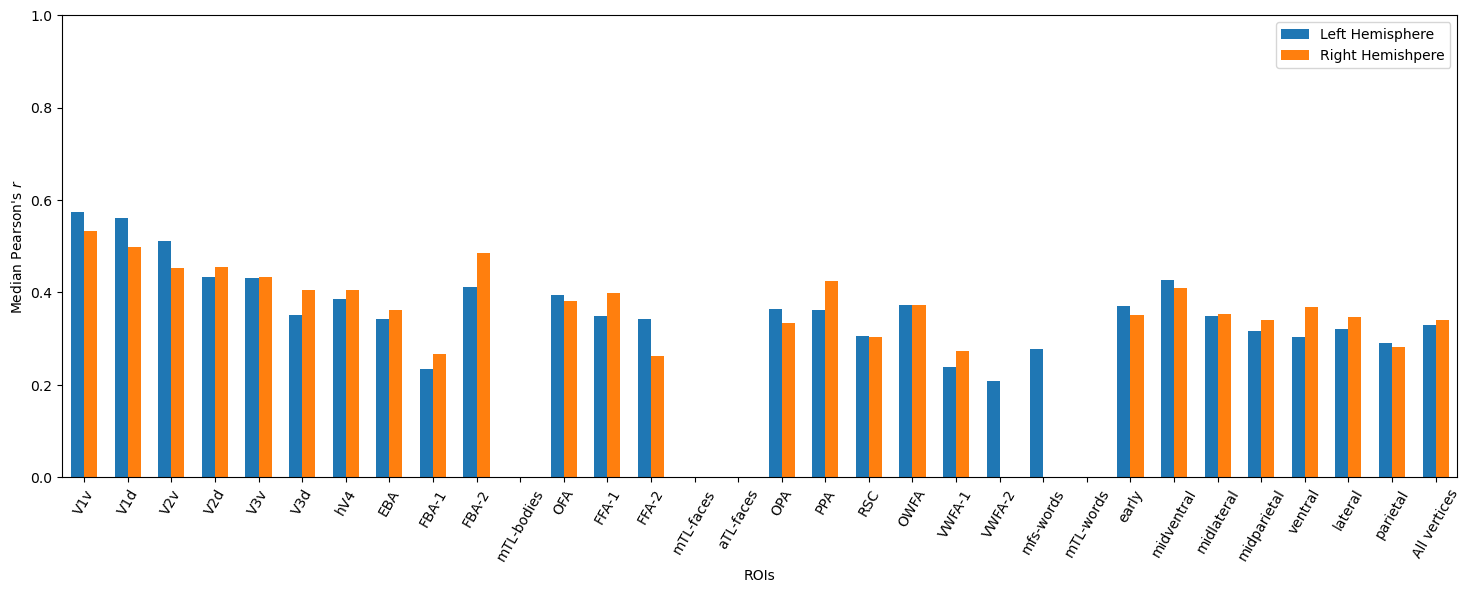

In [ ]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]

print(lh_median_roi_correlation[-1], rh_median_roi_correlation[-1])

plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);
plt.show()

In [ ]:
lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)